# Tutorial for PsPolypy

## Imports

In [1]:
# Import necessary libraries for this example
import numpy as np
from skimage import io
from skimage.util import img_as_float
from skimage.color import rgb2gray, rgba2rgb
import scipy

from IPython.display import display, Math

# Locate PsPolypy. Only necessary if PsPolypy is not installed as a package.
import sys
sys.path.append('../src/')

# Import PsPolypy
import  PsPolypy

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
from cycler import cycler

# rcParams settings

plt.rcParams['axes.prop_cycle'] = cycler(color='krbmgcy')

plt.rcParams['axes.linewidth'] = 1.5

plt.rcParams['xtick.top'] = plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 8 
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = plt.rcParams['ytick.major.width'] = 1; 
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['savefig.transparent']=True

plt.rcParams['legend.framealpha'] = 0.6
plt.rcParams['legend.markerscale'] = 2.
plt.rcParams['legend.fontsize'] = 'xx-large'
plt.rcParams['figure.subplot.wspace'] = 0.02
plt.rcParams['figure.subplot.hspace'] = 0.02
plt.rcParams['axes.labelpad'] = 5.
plt.rcParams['figure.dpi'] = 300

plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['figure.figsize'] = (8, 6)

plt.rcParams["font.family"]='serif'
plt.rcParams["mathtext.fontset"]='stix';

## The Polydat Object

### Properties Overview

```Polydat``` is the main object that stores and processes image fields containing polymer particles. The object can handle any number of full field images, provided they are the same nm/px resolution. A general outline of ```Polydat```'s properties is shown here:

```project
Polydat Properties
├─ images (list[np.ndarray])
│    └─ A list of full-field image arrays (2D numpy arrays) loaded into the object.
│
├─ resolution (float)
│    └─ The image resolution in nanometers per pixel.
│
├─ metadata (Dict[str, Any])
│    └─ A dictionary containing metadata for the experiment or data file
│         (e.g., {'recorded_on': '2024-12-25'}).
│
├─ particles (list[Particle])
│    └─ A list of Particle objects representing detected polymer particles.
│         Populated by the segment_particles() method.
│
├─ included_classifications (list[str])
│    └─ A list of particle classifications currently included in the analysis
│         (e.g., ['Linear', 'Branched', …]).
│         Updated by filter_particles().
│
├─ num_particles (Dict[str, int])
│    └─ A dictionary with counts of particles by classification
│         (e.g., {"All": 12, "Linear": 5, …}).
│         Updated when particles are segmented and classified.
│
├─ contour_lengths (list[float])
│    └─ A list of all contour lengths (in nm) from every skeletonized particle branch.
│         Set by interpolate_skeletons().
│
├─ contour_sampling (np.ndarray)
│    └─ A 1D array of contour-length sample points (from 0 to max length)
│         used for interpolating skeleton coordinates.
│         Set by interpolate_skeletons().
│
├─ mean_squared_displacements (np.ndarray)
│    └─ A 1D array representing the average squared displacements for all interpolated subpaths,
│         plotted versus contour length.
│
├─ mean_tantan_correlation (np.ndarray)
│    └─ A 1D array containing the mean tangent–tangent correlation of all skeleton paths at each contour-length
│         separation. Calculated by calc_tantan_correlations().
│
├─ displacement_sq_confidence_intervals (np.ndarray)
│    └─ A 2D array (N×2) providing lower/upper confidence bounds for mean squared displacements
│         at each contour-length step.
│
├─ tantan_confidence_intervals (np.ndarray)
│    └─ A 2D array (N×2) providing lower/upper confidence bounds for mean tan–tan correlations
│         at each contour-length step.
│
├─ R2_fit_result (lmfit.model.ModelResult)
│    └─ The lmfit ModelResult from fitting the end-to-end distance squared model.
│         The best-fit persistence length (lp) can be retrieved via R2_fit_result.params['lp'].value.
│
├─ tantan_fit_result (lmfit.model.ModelResult)
│    └─ The lmfit ModelResult from fitting the tan–tan correlation model.
│         The best-fit persistence length (lp) is available as tantan_fit_result.params['lp'].value.
│
├─ min_fitting_length (float)
│    └─ The lower bound (in nm) of the contour-length region used when fitting
│         persistence-length models.
│
└─ max_fitting_length (float)
     └─ The upper bound (in nm) of the contour-length region used for fitting.
```

### Methods Overview

Once an instance of ```polydat``` has been initialized, many different analysis methods can be performed. An overview of the available methods is shown here.

```project
Polydat Methods
├─ __init__(images: list[np.ndarray] = None, resolution: float = None, **metadata: Any) -> None
│    Initialize a new Polydat instance with images, resolution, and metadata.
│
├─ Static Methods
│    ├─ __load_with_skimage(filepath: str) -> np.ndarray
│    │      Loads an image file using skimage.io.imread, converts it to grayscale,
│    │      and handles channel conversion (RGBA/RGB) as needed.
│    │
│    ├─ __exponential_model(x, lp)
│    │      Implements an exponential decay model used for tan–tan correlation fitting.
│    │
│    └─ __R2_model(x, lp)
│           Implements the end-to-end distance squared model used for persistence length fitting.
│
├─ Class Methods
│    └─ from_images(filepaths: list[str], resolution: float, **metadata) -> Polydat
│           Create a Polydat instance from a list of image file paths by loading each image.
│
├─ Main Methods
│    ├─ add_image(filepath: str, resolution: float) -> list[np.ndarray]
│    │      Loads an image from the given file and appends it to the image list.
│    │
│    ├─ upscale(magnification: float, order: int = 3) -> Tuple[list[np.ndarray], float]
│    │      Upscales all images by the specified magnification factor (using interpolation) and
│    │      updates the resolution and metadata.
│    │
│    ├─ segment_particles(minimum_area: int = 10, padding: int = 1) -> list[Particle]
│    │      Segments particles from full-field images via thresholding and connected region labeling;
│    │      creates and stores Particle objects.
│    │
│    ├─ skeletonize_particles(method: str = 'zhang') -> list[Particle]
│    │      Skeletonizes each Particle’s image; removes particles with insufficient skeleton data.
│    │
│    ├─ classify_particles() -> list[Particle]
│    │      Classifies each Particle (e.g., Linear, Branched, etc.) and updates particle counts.
│    │
│    ├─ filter_particles(classifications: list[str]) -> list[Particle]
│    │      Filters the Particle list to include only those with specified classifications.
│    │
│    ├─ interpolate_skeletons(step_size: float, k: int = 3, s: float = 0.5) -> None
│    │      Interpolates the skeletons for each particle (using spline interpolation) to obtain
│    │      subpixel contour coordinates.
│    │
│    ├─ calc_displacements() -> None
│    │      Computes the mean squared displacements along each interpolated path from all particles,
│    │      including calculation of standard deviations and SEM for error bars.
│    │
│    ├─ calc_tantan_correlations() -> None
│    │      Computes the tangent–tangent correlations (and associated error metrics) from each particle.
│    │
│    ├─ calc_R2_lp(lp_init: float = 10,
│    │              min_fitting_length: float = 0,
│    │              max_fitting_length: float = np.inf,
│    │              **fit_kwargs) -> None
│    │      Fits the end-to-end distance squared (R²) model to the mean squared displacement data
│    │      to estimate the persistence length (lp) using lmfit.
│    │
│    └─ calc_tantan_lp(lp_init: float = 10,
│                   min_fitting_length: float = 0,
│                   max_fitting_length: float = np.inf,
│                   **fit_kwargs) -> None
│           Fits the exponential decay (tan–tan correlation) model to estimate the persistence length.
│
├─ Plotting Methods
│    ├─ plot_image(index: int = 0, ax: plt.Axes = None, **kwargs) -> plt.Axes
│    │      Plots one of the full-field images.
│    │
│    ├─ plot_particle(index: int, ax: plt.Axes = None, **kwargs) -> plt.Axes
│    │      Plots the image and details for a specific Particle.
│    │
│    ├─ plot_skeleton(index: int, ax: plt.Axes = None, **kwargs) -> plt.Axes
│    │      Plots the skeleton (binary representation) of a given Particle.
│    │
│    ├─ plot_interpolated_skeleton(index: int, ax: plt.Axes = None, **kwargs) -> plt.Axes
│    │      Plots the interpolated skeleton (smooth path) of a Particle.
│    │
│    ├─ plot_contour_distribution(n_points: int = 100, ax: plt.Axes = None, …) -> plt.Axes
│    │      Uses Gaussian KDE to plot the distribution of all contour lengths from particle branches,
│    │      highlighting the included versus excluded fitting ranges.
│    │
│    ├─ plot_subpath_contour_distribution(n_points: int = 100, ax: plt.Axes = None, …) -> plt.Axes
│    │      Similar to plot_contour_distribution but for subpath contour lengths.
│    │
│    ├─ plot_mean_squared_displacements(error_bars: bool = False,
│    │                                    ax: plt.Axes = None,
│    │                                    inc_kwargs: dict = None,
│    │                                    exc_kwargs: dict = None,
│    │                                    vline_kwargs: dict = None) -> plt.Axes
│    │      Plots the mean squared displacements versus contour length with optional error bars,
│    │      and distinguishes data within the fitting range.
│    │
│    ├─ plot_mean_squared_displacements_fit(ax: plt.Axes = None,
│    │                                         show_init: bool = False,
│    │                                         fit_kwargs: dict = None,
│    │                                         init_kwargs: dict = None) -> plt.Axes
│    │      Overlays the fitted R² model (and optionally the initial guess) on the displacement data.
│    │
│    ├─ plot_mean_tantan_correlations(error_bars: bool = False,
│    │                                  ax: plt.Axes = None,
│    │                                  inc_kwargs: dict = None,
│    │                                  exc_kwargs: dict = None,
│    │                                  vline_kwargs: dict = None) -> plt.Axes
│    │      Plots the mean tangent–tangent correlations with optional error bars,
│    │      differentiating between included and excluded data.
│    │
│    └─ plot_mean_tantan_correlations_fit(ax: plt.Axes = None,
│                                          show_init: bool = False,
│                                          fit_kwargs: dict = None,
│                                          init_kwargs: dict = None) -> plt.Axes
│           Overlays the fitted exponential decay (tan–tan) model on the correlation data.
│
├─ Printing/Summary Methods
│    ├─ print_image_summary() -> None
│    │      Prints a summary of the image data (number of images, resolution, and upscaling details).
│    │
│    ├─ print_classification_summary() -> None
│    │      Prints a summary of particle segmentation and classification counts.
│    │
│    ├─ print_pl_summary() -> None
│    │      Prints a summary of persistence length (lp) calculations, including fit details.
│    │
│    └─ print_summary() -> None
│           Prints a complete summary combining image, classification, and persistence length data.
│
└─ Data Extraction Methods
     ├─ squared_displacements_at_lag(lag: int = 0) -> np.ndarray
     │      Returns an array of squared displacements for a specified lag.
     │
     └─ tantan_correlations_at_lag(lag: int = 0) -> np.ndarray
            Returns an array of tan–tan correlations for a specified lag.

```

## The Particle Object

### Properties Overview

During ```polydat``` processing, ```particle``` images are made each encapsulating a feature detectedin the polymer field image. An overview of available properties of the ```particle``` object is shown here.
```project
Particle Properties
├─ image (np.ndarray)
│    └─ The image of the particle.
│
├─ resolution (float)
│    └─ The resolution of the image in nanometers per pixel.
│
├─ bbox (Tuple[int, int, int, int])
│    └─ The bounding box coordinates of the particle in the full field image.
│
├─ binary_mask (np.ndarray)
│    └─ The binary mask of the particle.
│
├─ classification (str)
│    └─ The classification of the particle (e.g., Linear, Branched, Looped, Branched-Looped, or Unknown).
│
├─ id (int)
│    └─ The unique identifier for the particle.
│
├─ skeleton (skan.Skeleton)
│    └─ The skeleton representation of the particle, generated from its binary mask.
│
├─ skeleton_summary (pandas.DataFrame)
│    └─ A summary of the skeleton properties (as generated by skan) used for classification.
│
├─ contour_samplings (list[np.ndarray])
│    └─ A list of contour sampling arrays for each skeleton path (the sampled positions along each contour).
│
├─ contour_lengths (list[float])
│    └─ The contour lengths (in nm) of each skeleton path.
│
├─ interp_skeleton_coordinates (list[np.ndarray])
│    └─ The interpolated skeleton coordinates for each path (providing subpixel accuracy).
│
├─ interp_skeleton_derivatives (list[np.ndarray])
│    └─ The derivatives of the interpolated skeleton paths, used for tangent calculations.
│
├─ displacements (list[np.ndarray])
│    └─ The displacements calculated along each skeleton path.
│
└─ tantan_correlations (list[np.ndarray])
     └─ The tangent–tangent (Tan-Tan) correlations computed for each path.
```

### Methods Overview

```project
Particle Methods
├─ __init__(image: np.ndarray, resolution: float, bbox: Tuple[int, int, int, int],
│           binary_mask: np.ndarray = None, classification: str = None, id: int = None) -> None
│         Initialize a Particle object by setting the image, resolution, bounding box, binary mask,
│         classification, and particle ID. Also initializes additional processing attributes.
│
├─ Main Processing Methods
│    ├─ skeletonize_particle(method: str = 'zhang') -> Tuple[skan.Skeleton, pandas.DataFrame]
│    │      Skeletonize the particle's binary mask using the specified method, set the skeleton and
│    │      skeleton_summary attributes, and return both.
│    │
│    ├─ classify() -> str
│    │      Classify the particle (e.g., as Linear, Branched, Looped, Branched-Looped, or Unknown)
│    │      based on its skeleton summary; update and return the classification.
│    │
│    ├─ interpolate_skeleton(step_size: float, k: int = 3, s: float = 0.5)
│    │      -> Tuple[list[np.ndarray], list[float], list[np.ndarray], list[np.ndarray]]
│    │      Interpolate each skeleton path using spline interpolation (with the specified step size,
│    │      degree *k*, and smoothing factor *s*) to compute:
│    │          - Contour samplings,
│    │          - Contour lengths,
│    │          - Interpolated skeleton coordinates, and
│    │          - Interpolated skeleton derivatives.
│    │      Set the corresponding attributes and return these values.
│    │
│    ├─ calc_displacements() -> list[np.ndarray]
│    │      Compute displacement matrices for each interpolated skeleton path, extract subpath
│    │      displacements, and return a list of displacement arrays.
│    │
│    └─ calc_tantan_correlation() -> list[np.ndarray]
│           Compute the tangent–tangent (Tan-Tan) correlations for each interpolated path based on
│           the unit tangent vectors and return a list of correlation arrays.
│
└─ Plotting Methods
     ├─ plot_particle(ax: plt.Axes = None, **kwargs) -> plt.Axes
     │      Plot the particle's image on a given (or current) matplotlib axis.
     │
     ├─ plot_skeleton(ax: plt.Axes = None, **kwargs) -> plt.Axes
     │      Plot the particle’s skeleton (from the skeleton attribute) on a matplotlib axis.
     │
     └─ plot_interpolated_skeleton(ax: plt.Axes = None, **kwargs) -> plt.Axes
            Plot the spline-interpolated skeleton paths (using the interpolated coordinates)
            on a matplotlib axis.
```

## Step-By-Step Workflow

### Creating an instance of Polydat

There are three means of creating an instance of the ```Polydat``` class.```from_images``` for creates an instance of ```Polydat``` from a list of image files. An empty ```Polydat``` instance can be created, and images can be added with the ```add_image``` method. Finally, a list of images can be passed to the built-in initialization function for ```polydat```. These options are shown below.

In [3]:
# Create an instance of the Polydat class from a single image. Note, it must be a list of file paths, even if there is only one image.
image_path = ['example_images/exampleCL0.png']
polydat = PsPolypy.Polymer.Polydat.from_images(image_path, resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The first polydat object contains {len(polydat.images)} image(s).')

# Example of creating an instance of the Polydat class from a list of image file paths.
image_paths = ['example_images/exampleCL0.png', 'example_images/exampleCL1.png']
polydat = PsPolypy.Polymer.Polydat.from_images(image_paths, resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The second polydat object contains {len(polydat.images)} image(s).')

The first polydat object contains 1 image(s).
The second polydat object contains 2 image(s).


In [4]:
# Create an empty instance of the Polydat class and add an image to it.
polydat = PsPolypy.Polymer.Polydat()
polydat.add_image('example_images/exampleCL0.png', resolution = 2)
polydat.add_image('example_images/exampleCL1.png', resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The polydat object contains {len(polydat.images)} image(s).')

The polydat object contains 2 image(s).


In [5]:
# Create an instance of the Polydat class from a list of numpy arrays.
filepath = 'example_images/exampleCL0.png'
image = io.imread(filepath)
image_data = img_as_float(rgba2rgb(image))
polydat = PsPolypy.Polymer.Polydat([image_data], resolution = 2)
# Check that the polydat object has been created correctly.
print(f'The polydat object contains {len(polydat.images)} image(s).')

The polydat object contains 1 image(s).


### Upscaling images with Polydat

The first method for processing the image(s) is to (optionally) upscale them. The ```upscale``` method takes two inputs, ```magnification``` (int/float) and ```order``` (int). Each image has its shape multiplied by the ```magnification``` factor and interpolated by a 2D spline of ```order``` power. The upscaled image is set set back in the ```images``` attribute, i.e. this operation occurs in place. Furthermore, the ```resolution``` attribute is dynamically updated to reflect the new nm/px value. 

Note:

```upscale``` method raises an exception if the ```upscaled``` metadata is ```True```. This prevents upscaled images from being upscaled multiple times. After ```upscale``` is executing the ```metadata``` will be automatically updated with ```upscaled: True```. 

Though ```magnification```may be a floating point number, this may lead to warped images and unexpected behavior; it is preferrable to keep the magnification factor an integer. The interpolation ```order``` must be an integer from 0 to 5, indicating nearest-neighbor to bi-quintic interpolation. The default interpolation order is 3: bi-cubic. 

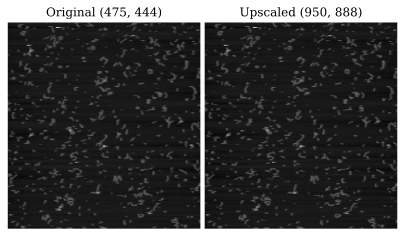

In [6]:
# Create an instance of the Polydat class from the test image.
image_path = ['example_images/exampleCL0.png']
polydat = PsPolypy.Polymer.Polydat.from_images(image_path, resolution = 2)
# Extract the image from the polydat object.
base_image = polydat.images[0]

# Upscale the image by a factor of 2 using bi-cubic interpolation.
polydat.upscale(magnification = 2, order = 3)
# Extract the upscaled image from the polydat object.
upscaled_image = polydat.images[0]

# Plot the original and upscaled images for comparison.
fig, ax = plt.subplots(1,2, figsize = (7,6))
for axis in ax:
    axis.axis('off')

# Display the images.
ax[0].imshow(base_image, cmap = 'gray')
ax[0].set_title(f'Original {base_image.shape}')
ax[1].imshow(upscaled_image, cmap = 'gray')
ax[1].set_title(f'Upscaled {upscaled_image.shape}')

# Display the plot.
plt.show()

The ```segment_particles``` method segments the images in the ```polydat``` instance. This method takes two optional arguments: ```minimum_area``` (int) and ```padding``` (int). During segmentation, any particle whose area is less than ```minimum_area``` is discarded. ```padding``` indicates how many padding pixels to include around the cropped region surrounding each particle.

In [7]:
# Segment the particles in the image.
polydat.segment_particles()

# Check to see how many particles were detected.
print(f'The polydat object detected and segmented {polydat.num_particles} particles.')

The polydat object detected and segmented {'All': 416, 'Linear': 0, 'Branched': 0, 'Looped': 0, 'Branched-Looped': 0, 'Unknown': 0} particles.


The segmented particles can be visualized with ```plot_particle```. It takes the argument ```index``` for which particle to plot.

**Note:** All plotting functions take the optional argument ```ax``` which chooses the ```matplotlib.pyplot.axis``` to draw to. If not explicitly specified, the current axis is selected with ```matplotlib.pyplot.gca```. For more information, see the Matplotlib documentation [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gca.html).

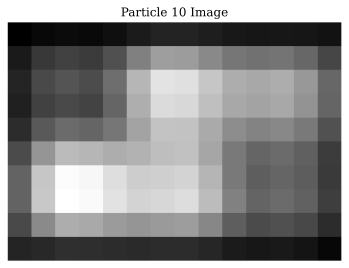

In [8]:
# Select which particle to view the image of.
particle_index = 10

# Create the figure and the axis for the particle image.
particle_fig, ax = plt.subplots(figsize = (6,6))
# Plot the image to the axis.
polydat.plot_particle(particle_index, ax, cmap = 'gray')
# Set the title of the plot.
ax.set_title(f'Particle {particle_index} Image')
# Turn the axis off
ax.axis('off')
# Display the plot.
plt.show()

The ```skeletoinize_particles``` method creates skan skeleton representations of each ```particle```.

In [9]:
# Skeletonize the particles with the default parameters.
polydat.skeletonize_particles()

The skeletons can be visualized with ```plot_skeleton```. It takes the argument ```index``` for which skeleton to plot.

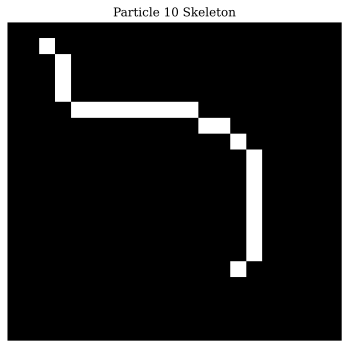

In [10]:
# Select which particle to view the skeleton of.
particle_index = 10

# Create the figure and the axis for the skeleton image.
skeleton_fig1, ax = plt.subplots(figsize = (6,6))
# Plot the skeleton image to the axis.
ax = polydat.plot_skeleton(particle_index, cmap = 'gray')
# Set the title of the plot.
ax.set_title(f'Particle {particle_index} Skeleton')
# Turn the axis off
ax.axis('off')
# Display the plot.
plt.show()

```interpolate_skeletons``` interpolates each particle skeleton along the contur in a user defined ```step_size``` (float). ```step_size``` can be set below 1 to sample the contour above the current pixel resolution. The optional arguments for the interpolation order ```k``` (int) and smoothing ```s``` (float) are passed to ```scipy.interpolate.splprep```. For more information see the scipy documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splprep.html#scipy.interpolate.splprep).

```plot_interpolated_skeleton``` will now display the interpolated skeleton contour.

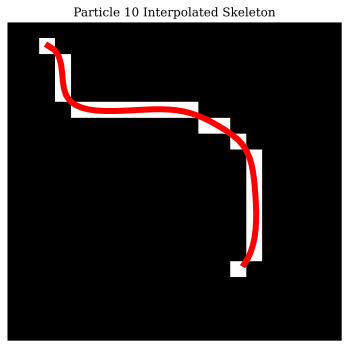

In [11]:
# Interpolate the skeletons of the particles.
polydat.interpolate_skeletons(step_size = 0.5, k = 3, s = 0.5)

# Select which particle to view the interpolated skeleton of.
particle_index = 10

# Create the figure and the axis for the skeleton image.
skeleton_fig2, ax = plt.subplots(figsize = (6,6))
# Plot the skeleton image to the axis.
polydat.plot_skeleton(particle_index, ax, cmap = 'gray',alpha=1)
# Plot the interpolated skeleton to the axis.
polydat.plot_interpolated_skeleton(particle_index, ax, lw = 6, color = 'red')
# Set the title of the plot.
ax.set_title(f'Particle {particle_index} Interpolated Skeleton')
# Turn the axis off
ax.axis('off')
# Display the plot.
plt.show()

```plot_contour_distribution``` plots a distribution of all particle contour lengths. This plotting takes in ```Dict```s of keyword arguments passed to matplotlib. The kwargs for controling the plot are ```inc_dist_kwargs``` and ```inc_fill_kwargs``` for the distribtuion and fill respectively. See the docstring for more information.

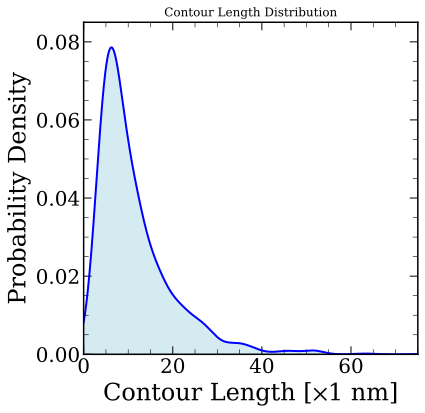

In [12]:
# Create the figure and the axis for the contour distribution.
contour_distribution_fig1, ax = plt.subplots(figsize = (6,6))

# Plot the contour length distribution.
ax = polydat.plot_contour_distribution(n_points = 1000,
                                       inc_dist_kwargs = {'color': 'Blue', 'lw': 2,},
                                       inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5})
# Set the title of the plot.
ax.set_title('Contour Length Distribution')
# Set the axis labels.
ax.set_xlabel(fr'Contour Length [$\times${polydat.resolution:.0f} nm]')
ax.set_ylabel('Probability Density')
# Set the axis limits.
ax.set_ylim([0,0.085])
ax.set_xlim([0,75])
plt.show()

### Classifying The Particles

```classify_particles``` sets the ```classification``` attribute of each particle. Each particle is classified by the following criteria:
- If the particle contains a single branch path with two different endpoints, the particle is classified as ```Linear```.
- If the particle contains a single branch path with the same end points, the particle is classified as ```Looped```.
- If the particle contains multiple branch paths that intersect at a branch point but no cycles (A point can be revisited when traveling along a set of branch paths), the particle is classified as ```Branched```.
- If the particle contains multiple branch paths that intersect at a branch point and includes cycles, the particle is classified as ```Brached-Looped```.
- If none of the above criteria are met, the particle is classified as ```Unknown```. This should not occur, but is included for safety.

```filter_particles``` takes the argument ```classifications``` (list[str]). This removes all particles from the ```polydat``` instance whose classification is not in the list.

The number of linear particles is 225.


(np.float64(-0.5), np.float64(11.5), np.float64(15.5), np.float64(-0.5))

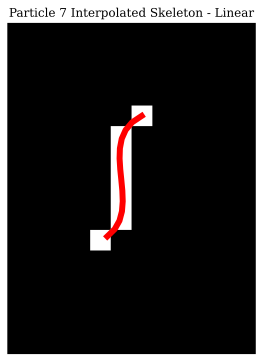

In [13]:
# Classify the Particles
polydat.classify_particles()

# Get the number of particles in the Linear classification.
linear_particles = [particle for particle in polydat.particles if particle.classification == 'Linear']
print(f'The number of linear particles is {len(linear_particles)}.')

# Select the first particle in the Linear classification.
particle = linear_particles[0]

# Create the figure and the axis for the particle image.
linear_skeleton_fig, ax = plt.subplots(figsize = (6,6))
# Plot the first particle's skeleton.
ax = particle.plot_skeleton(cmap = 'gray')
# Plot the first particle's interpolated skeleton.
ax = particle.plot_interpolated_skeleton(lw = 6, color = 'red')
# Set the title of the plot.
ax.set_title(f'Particle {particle.id} Interpolated Skeleton - {particle.classification}')
# Turn the axis off
ax.axis('off')

### Calculating the Persistence Length

```calc_tantan_correlations``` calculates the Tangent-Tangent correlation for all pairs of points in all paths. The correlations are averaged for each contour length and ```mean_tantan_correlation``` is set.. 

```plot_mean_tantan_correlation``` creates a plot of the mean Tangent-Tangent correlation. It takes a single optional argument ```error_bars``` (bool) to turn error bars on and off. Furthermore, the plotting function includes keyword argument dictionaries ```inc_kwargs``` and ```exc_kwargs``` for altering the color of the correlation, its errorbars, etc. See the source code for more information.

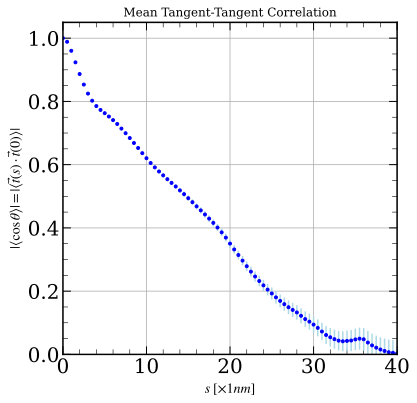

In [14]:
# Calculate the tangent-tangent correlation functions for all the particles.
polydat.calc_tantan_correlations()

tantan_correlation_fig1, ax = plt.subplots(figsize = (6,6))
# Plot the mean tangent-tangent correlation function.
polydat.plot_mean_tantan_correlations(error_bars = True,
                                          inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'LightBlue'},
                                          exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'LightGray'})
# Set the title of the plot.
ax.set_title('Mean Tangent-Tangent Correlation')
# Set the axis labels.
ax.set_xlabel(fr'$s\; [\times{polydat.resolution:.0f} nm]$',fontsize=14)
ax.set_ylabel(r'$|\langle\cos\theta\rangle|=|\langle\vec{t}(s)\cdot\vec{t}(0)\rangle|$',fontsize=14)
# Set the axis limits.
ax.set_xlim(0,40)
ax.set_ylim(0,1.05)
# Turn the grid on.
ax.grid()
# Display the plot.
plt.show()

```plot_subpath_contour_distribution``` plots a distribution of all particle subpath contour lengths. This plotting takes in ```Dict```s of keyword arguments passed to matplotlib. The kwargs for controling the plot are ```inc_dist_kwargs``` and ```inc_fill_kwargs``` for the distribtuion and fill respectively. See the docstring for more information.

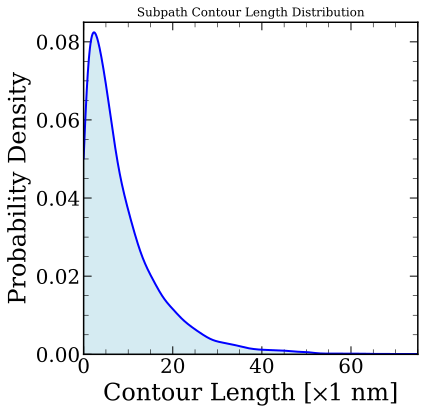

In [15]:
# Create the figure and the axis for the contour distribution.
subpath_contour_distribution_fig, ax = plt.subplots(figsize = (6,6))

# Plot the contour length distribution.
ax = polydat.plot_subpath_contour_distribution(n_points = 1000,
                                               inc_dist_kwargs = {'color': 'Blue', 'lw': 2,},
                                               inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5})
# Set the title of the plot.
ax.set_title('Subpath Contour Length Distribution')
# Set the axis labels.
ax.set_xlabel(fr'Contour Length [$\times${polydat.resolution:.0f} nm]')
ax.set_ylabel('Probability Density')
# Set the axis limits.
ax.set_ylim([0,0.085])
ax.set_xlim([0,75])
plt.show()

```calc_tantan_lp``` fits the mean Tangent-Tangent correlation to calculate the persistence length. It accepts two optional arguments, ```min_fitting_length``` (float) and ```max_fitting_length``` (float). Because the correlation contribution from low contour lengths can bias the fit, and the sampling of very long contour lengths is very low, the decaying exponential is only fit between these two values. Executing ```calc_tantan_lp``` sets the ```tantan_fit_result``` parmeter with a ```lmfit.model.ModelResult```. For more information about the result see the documentation [here](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult).

```print_summary``` prints a summary of the analysis performed. ```plot_mean_tantan_correlation_fit``` plots the fitted exponential. If the ```show_init``` argument is ```True```, the initial guess at the fit is shown along side the best fit. The ```init_kwargs``` can be set to adjust the parameters of the initial guess plot.

Polymer Data Summary
----------------------------------------------------------------
Image Summary:
Number of Images:			2
Base Resolution:			2.0 nm/pixel
Upscaled:				True
Magnification Factor:			2.0
Interploation Order:			3
Upscaled Resolution:			1.0 nm/pixel
----------------------------------------------------------------
Segmentation/Classification Summary:
All Particles:				615
Linear Particles:			376
Branched Particles:			141
Branched-Looped Particles:		89
Looped Particles:			1
Unknown Particles:			0
----------------------------------------------------------------
Persistence Length Summary:
Included Classifications:		All
Minimum Fitting Contour Length:		10.0 nm
Maximum Fitting Contour Length:		30.0 nm
Tan-Tan Correlation lp:			13.6 +/- 0.1 nm
Tan-Tan Correlation Reduced Chi^2:	14.53


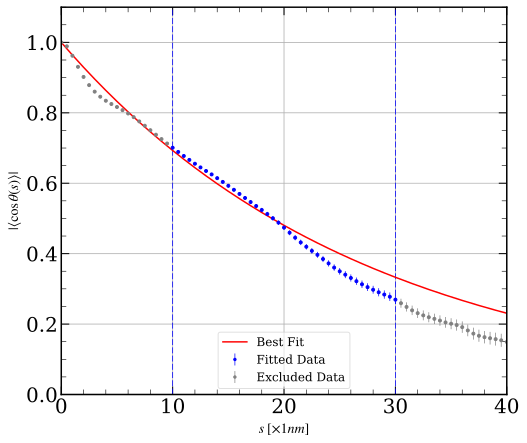

In [23]:
# Calculate the persistence length of the particles.
L_min = 10
L_max = 30
polydat.calc_tantan_lp(min_fitting_length = L_min, max_fitting_length = L_max)

# Print a summary of the polydat object.
polydat.print_summary()

tantan_correlation_fig2, ax = plt.subplots(figsize = (8,7))
# Plot the mean tangent-tangent correlation function.
polydat.plot_mean_tantan_correlations(ax = ax, error_bars = True,
                                          inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'Blue', 'lw': 0.7, 'label': 'Fitted Data'},
                                          exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'Gray', 'lw': 0.7, 'label': 'Excluded Data'},
                                          vline_kwargs = {'color': 'Blue', 'lw': 0.75, 'dashes': [8,3]})
# Plot the fitted decaying exponential.
polydat.plot_mean_tantan_correlations_fit(ax = ax,show_init = False,
                                              fit_kwargs = {'color': 'Red', 'lw': 1.5, 'label': 'Best Fit'},
                                              init_kwargs = {'color': 'Red', 'lw': 0.75, 'linestyle': '--', 'label': 'Initial Guess'})

# Set the title of the plot.
# ax.set_title('Mean Tangent-Tangent Correlation')

# Set the axis labels.
ax.set_xlabel(rf'$s\;[\times{polydat.resolution:.0f} nm]$',fontsize=14)
ax.set_ylabel(r'$|\langle\cos\theta(s)\rangle|$',fontsize=14)

# Set legend
ax.legend(markerscale=0.8,fontsize=12)

# Set the axis limits.
ax.set_xlim(0,40)
ax.set_ylim(0,1.1)
# Turn the grid on.
ax.grid()
# Display the plot.
plt.show()

### Tangent-Tangent Correlation

Below is an example of the end-to-end workflow for processing a set of polymer images for all classification types using the Tangent-Tangent Correlation Method.

Polymer Data Summary
----------------------------------------------------------------
Image Summary:
Number of Images:			2
Base Resolution:			2.0 nm/pixel
Upscaled:				True
Magnification Factor:			2.0
Interploation Order:			3
Upscaled Resolution:			1.0 nm/pixel
----------------------------------------------------------------
Segmentation/Classification Summary:
All Particles:				615
Linear Particles:			376
Branched Particles:			141
Branched-Looped Particles:		89
Looped Particles:			1
Unknown Particles:			0
----------------------------------------------------------------
Persistence Length Summary:
Included Classifications:		All
Minimum Fitting Contour Length:		10.0 nm
Maximum Fitting Contour Length:		30.0 nm
Tan-Tan Correlation lp:			13.6 +/- 0.1 nm
Tan-Tan Correlation Reduced Chi^2:	14.53


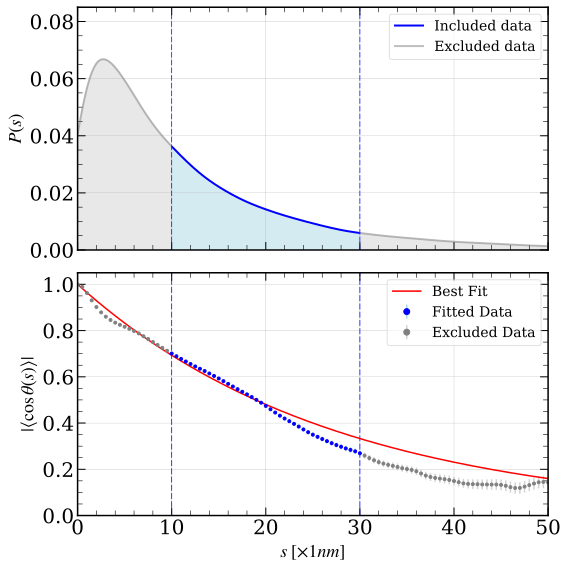

<IPython.core.display.Math object>

--------------------------------


<IPython.core.display.Math object>

In [24]:
# Create a list of the files to be analyzed.
filepaths = ['example_images/exampleCL0.png', 'example_images/exampleCL1.png']

# Create an instance of the Polydat class from the list of file paths.
polydat = PsPolypy.Polymer.Polydat.from_images(filepaths = filepaths, resolution = 2)

# Upscale the image by a factor of 2 using bi-cubic interpolation.
polydat.upscale(magnification = 2, order = 3)

# Segment the particles in the image.
polydat.segment_particles()

# Skeletonize the particles.
polydat.skeletonize_particles()

# Classify the particles.
polydat.classify_particles()

# Interpolate the skeletons of the particles.
polydat.interpolate_skeletons(step_size = 0.5, k = 3, s = .5)

# Calculate the tangent-tangent correlation for the particles.
polydat.calc_tantan_correlations()

# Calculate the persistence length.
L_min = 10
L_max = 30
polydat.calc_tantan_lp(lp_init = 11, min_fitting_length = L_min, max_fitting_length = L_max, scale_covar = True)

# Print a summary of the polydat object.
polydat.print_summary()

# Create a figure containing the complete workflow plots.
fig_ttc, ax = plt.subplots(2,1, figsize = (8,8),sharex=True)
    
# Plot contour length distribution
polydat.plot_subpath_contour_distribution(ax = ax[0], n_points = 1000,
                                  inc_dist_kwargs = {'color': 'Blue', 'lw': 2, 'label': 'Included data'},
                                  inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5},
                                  exc_dist_kwargs = {'color': 'Gray', 'lw': 2, 'alpha': 0.5, 'label': 'Excluded data'},
                                  exc_fill_kwargs = {'color': 'LightGray', 'alpha': 0.5},
                                  vline_kwargs = {'color': 'Blue', 'lw': 0.7, 'dashes': [8,3]})

ax[0].set_ylabel(r'$P(s)$',fontsize=18)
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,0.085])
ax[0].grid(lw=0.3)
ax[0].legend(fontsize = 14)

# Plot tangent-tangent correlation with the fit.
polydat.plot_mean_tantan_correlations(error_bars = True, ax = ax[1],
                                     inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'LightBlue', 'label': 'Fitted Data'},
                                     exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'LightGray', 'label': 'Excluded Data'})
polydat.plot_mean_tantan_correlations_fit(ax = ax[1],
                                         fit_kwargs = {'color': 'Red', 'lw': 1.5, 'label': 'Best Fit'},
                                         init_kwargs = {'color': 'Red', 'lw': 0.75, 'linestyle': '--', 'label': 'Initial Guess'})

ax[1].set_xlabel(rf'$s\;[\times{polydat.resolution:.0f} nm]$',fontsize=18)
ax[1].set_ylabel(r'$|\langle\cos\theta(s)\rangle|$',fontsize=18)
ax[1].set_xlim([0,50])
ax[1].set_ylim(0,1.05)
ax[1].grid(lw=0.3)
ax[1].legend(fontsize=14)

# Display the plot.
plt.tight_layout()
plt.show()
# Show the fitting results.
# polydat.tantan_fit_result


# Extract best-fit parameter and its standard deviation
result = polydat.tantan_fit_result
lp_0 = result.params['lp'].value
std_0 = result.params['lp'].stderr

# Goodness-of-fit measure (reduced chi-squared)
rchi2_0 = result.redchi  # Reduced chi-squared

# Scale the standard deviation only if reduced chi-squared is greater than 1
if rchi2_0 > 1.0:
    scaled_std_r2 = np.sqrt(rchi2_0) * std_0
else:
    scaled_std_r2 = std_0

# Display results
display(Math(rf"$\chi_{{red}}^2 = {rchi2_0:.2f}$"))
print('-' * 32)
display(Math(rf"$l_p = {lp_0:.1f} \pm {scaled_std_r2:.1f}$"))

result

### $\langle R^2\rangle$ - Mean Square End-To-End Distance

The above workflow can be performed to calculate the Mean Squared End-To-End distance and fit. Simply replace ```calc_tantan_correlations``` and ```calc_tantan_lp``` with ```calc_displacements``` and ```calc_R2_lp``` respectively. Below is an example of the end-to-end workflow for processing a set of polymer images for only linear particles using the Mean Squared End to End Distance Method.

Polymer Data Summary
----------------------------------------------------------------
Image Summary:
Number of Images:			2
Base Resolution:			2.0 nm/pixel
Upscaled:				True
Magnification Factor:			2.0
Interploation Order:			3
Upscaled Resolution:			1.0 nm/pixel
----------------------------------------------------------------
Segmentation/Classification Summary:
All Particles:				615
Linear Particles:			376
Branched Particles:			141	(Filtered Out)
Branched-Looped Particles:		89	(Filtered Out)
Looped Particles:			1	(Filtered Out)
Unknown Particles:			0	(Filtered Out)
----------------------------------------------------------------
Persistence Length Summary:
Included Classifications:		['Linear']
Minimum Fitting Contour Length:		10.0 nm
Maximum Fitting Contour Length:		40.0 nm
R^2 lp:					12.6 +/- 0.2 nm
R^2 Reduced Chi^2:			49.04


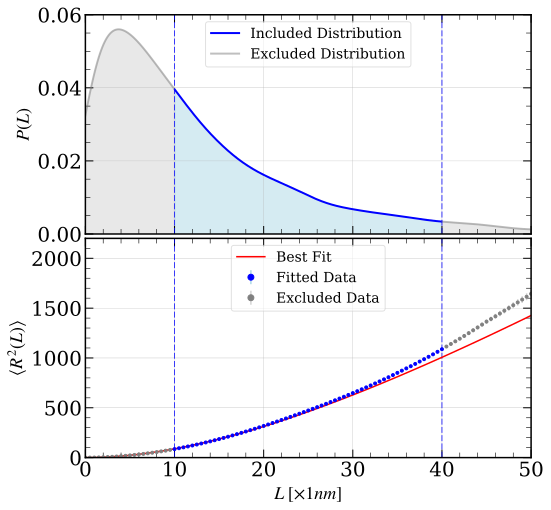

<IPython.core.display.Math object>

--------------------------------


<IPython.core.display.Math object>

In [19]:
# Create a list of the files to be analyzed.
filepaths = ['example_images/exampleCL0.png', 'example_images/exampleCL1.png']

# Create an instance of the Polydat class from the list of file paths.
polydat = PsPolypy.Polymer.Polydat.from_images(filepaths = filepaths, resolution = 2)

# Upscale the image by a factor of 2 using bi-cubic interpolation.
polydat.upscale(magnification = 2, order = 3)

# Segment the particles in the image.
polydat.segment_particles()

# Skeletonize the particles.
polydat.skeletonize_particles()

# Classify the particles.
polydat.classify_particles()

# Filter the particles to only include the Linear classification.
polydat.filter_particles(classifications = ['Linear'])

# Interpolate the skeletons of the particles.
polydat.interpolate_skeletons(step_size = 0.5, k = 3, s = .5)

# Calculate <R^2>
polydat.calc_displacements()

L_min = 10
L_max = 40
# Calculate the persistence length.
polydat.calc_R2_lp(lp_init = 11, min_fitting_length = L_min, max_fitting_length = L_max, scale_covar = True)

# Print a summary of the polydat object.
polydat.print_summary()

# Create a figure containing the complete workflow plots.
fig_R2, ax = plt.subplots(2,1, figsize = (8,8),sharex=True)

# Plot contour length distribution
ax[0] = polydat.plot_subpath_contour_distribution(ax = ax[0], n_points = 1000,
                                          inc_dist_kwargs = {'color': 'Blue', 'lw': 2, 'label': 'Included Distribution'},
                                          inc_fill_kwargs = {'color': 'LightBlue', 'alpha': 0.5},
                                          exc_dist_kwargs = {'color': 'Gray', 'lw': 2, 'alpha': 0.5, 'label': 'Excluded Distribution'},
                                          exc_fill_kwargs = {'color': 'LightGray', 'alpha': 0.5},
                                          vline_kwargs = {'color': 'Blue', 'lw': 0.75, 'dashes': [8,3]})

ax[0].set_ylim(0,0.06)
ax[0].set_ylabel(r'$P(L)$',fontsize=18)
ax[0].grid(lw=0.3)
ax[0].legend(fontsize = 14)

# Plot tangent-tangent correlation with the fit.
polydat.plot_mean_squared_displacements(ax = ax[1], error_bars = True,
                                        inc_kwargs = {'color': 'Blue', 'fmt': '.', 'ecolor': 'LightBlue', 'label': 'Fitted Data'},
                                        exc_kwargs = {'color': 'Gray', 'fmt': '.', 'ecolor': 'LightGray', 'label': 'Excluded Data'})
polydat.plot_mean_squared_displacements_fit(ax = ax[1], show_init = False,
                                            fit_kwargs = {'color': 'Red', 'lw': 1.5, 'label': 'Best Fit'},
                                            init_kwargs = {'color': 'Red', 'lw': 0.75, 'linestyle': '--', 'label': 'Initial Guess'})
ax[1].set_xlim([0,50])
ax[1].set_ylim(0,2200)
ax[1].set_xlabel(rf'$L\;[\times{polydat.resolution:.0f} nm]$',fontsize=18)
ax[1].set_ylabel(r'$\langle R^2(L)\rangle$',fontsize=18)


ax[1].grid(lw=0.3)
ax[1].legend(fontsize = 14)

# Display the plot.
plt.show()
# Show the fitting results.
# polydat.wlc_fit_result


# Extract best-fit parameter and its standard deviation
result = polydat.R2_fit_result
lp_0 = result.params['lp'].value
std_0 = result.params['lp'].stderr

# Goodness-of-fit measure (reduced chi-squared)
rchi2_0 = result.redchi  # Reduced chi-squared

# Scale the standard deviation only if reduced chi-squared is greater than 1
if rchi2_0 > 1.0:
    scaled_std_r2 = np.sqrt(rchi2_0) * std_0
else:
    scaled_std_r2 = std_0

# Display results
display(Math(rf"$\chi_{{red}}^2 = {rchi2_0:.2f}$"))
print('-' * 32)
display(Math(rf"$l_p = {lp_0:.1f} \pm {scaled_std_r2:.1f}$"))

result

## Versions of used packages 

In [22]:
%load_ext watermark
%watermark --python --packages numpy,scipy,networkx,skan,matplotlib,PIL,skimage,lmfit

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

numpy     : 2.0.2
scipy     : 1.15.1
networkx  : 3.4.2
skan      : 0.12.1
matplotlib: 3.10.0
PIL       : 11.1.0
skimage   : 0.25.0
lmfit     : 1.3.2

